## Intro

This notebook serves as a playground to create codes for 
1. ablating an image with text. 
2. passing the (original, ablated) image pair through a captioning network, and 
3. scoring the difference.

In [2]:
"""Imports and Paths"""
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
from scipy import misc

import json
from pprint import pprint
import sys
sys.path.insert(0, "coco-text/")  #directory for ablation codes

IMG_PATH = 'data/coco/'
IMG_TYPE = 'train2014'            #input directory to sample from
TMP_PATH = 'tmp/'                 #tmp folder to put tmp images, caption jsons, etc.
CAPTION_PATH = 'neuraltalk2/'       #captioning code folder

/Users/Grendel/Desktop/ML/textmatters/coco-text
loading annotations into memory...
0:00:02.832805
creating index...
index created!


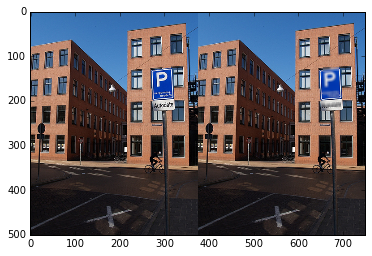

In [8]:
"""ablation"""
import ablation
import coco_text


text_data = coco_text.COCO_Text("coco-text/COCO_Text.json")
results = ablation.gen_ablation(mode = 'gaussian', ct = text_data, ksize=(7,7),sigma=7.)
# plt.subplot(1,2,1)
# plt.imshow(old)
# plt.subplot(1,2,2)
# plt.imshow(new)

for imgId, old, new in results:
    plot_image = np.concatenate((old, new), axis=1)
    plt.imshow(plot_image)
    misc.imsave(TMP_PATH+str(imgId)+"_orig.jpg",old)
    misc.imsave(TMP_PATH+str(imgId)+"_ablt.jpg",new)

In [19]:
"""Captioning.
For sake of convenience, use subprocess module to directly run torch command. """
import subprocess

run_cmd = "cd "+CAPTION_PATH + " && "+\
          "CUDA_VISIBLE_DEVICES=2 th eval.lua -model model/model_id1-501-1448236541.t7 " +\
          " -image_folder ../"+TMP_PATH+" && "+\
          " mv vis/vis.json ../tmp/"
# run_cmd = "ping -c4 www.google.com"
p = subprocess.Popen(run_cmd,shell=True, stdout=subprocess.PIPE)

#poll until finished
while True:
    out = p.stdout.readline()
    if out == '' and p.poll() != None:
        print "Exiting with {}".format(p.poll())
        break
    if out != '':
        print out

PING www.google.com (74.125.141.99): 56 data bytes

64 bytes from 74.125.141.99: icmp_seq=0 ttl=41 time=30.740 ms

64 bytes from 74.125.141.99: icmp_seq=1 ttl=41 time=29.403 ms

64 bytes from 74.125.141.99: icmp_seq=2 ttl=41 time=29.928 ms

64 bytes from 74.125.141.99: icmp_seq=3 ttl=41 time=29.048 ms



--- www.google.com ping statistics ---

4 packets transmitted, 4 packets received, 0.0% packet loss

round-trip min/avg/max/stddev = 29.048/29.780/30.740/0.637 ms

Exiting with 0


In [3]:
"""
Calculating semantic distance
"""
# from gensim import corpora, models, similarities
from semantic_dist import *

# load generated captions
with open(TMP_PATH+'vis.json') as f:
    result = json.load(f)

[{u'caption': u'a baseball player holding a bat on a field', u'image_id': u'1'}, {u'caption': u'a baseball player holding a bat on a field', u'image_id': u'2'}]


In [7]:
# split results
ablated = [d['caption'] for d in result[::2]]
original = [d['caption'] for d in result[1::2]]

stoplist = set('for a of the and to in its his her'.split())
ablated, original = pre_process(ablated, ignore=stoplist),pre_process(original, ignore=stoplist)
scores = map(lambda x: calc_inter_union(*x), zip(ablated, original))
print scores

[1.0]


# WARNING:
##### Below are unfinished code using gensim and LSI space to vectorize sentences.
##### Do not use yet.

In [34]:
#load coco-captions
with open("data/coco/annotations/captions_train2014.json") as f:
    captions = json.load(f)

#get document corpus from captions
sentences = [d['caption'] for d in captions['annotations']]
print len(sentences), sentences[1]

414113 [u'panoramic', u'view', u'kitchen', u'all', u'appliances.']


In [36]:
#remove meaningless words
stoplist = set('for a of the and to in its his her'.split())
texts = [ [word for word in sentence.lower().split() if word not in stoplist]
          for sentence in sentences ]

#remove words that only appear once
from collections import defaultdict
frequency = defaultdict(int) #int here is the default constructor for missing keys

for wlist in texts:
    for w in wlist:
        frequency[w]+=1

texts = [[ w for w in wlist if frequency[w]>1 ] for wlist in texts ]
print len(texts),texts[1]

414113 [u'panoramic', u'view', u'kitchen', u'all', u'appliances.']


In [43]:
#create dictionary and vectorization of each caption 
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print corpus[1]

[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]


In [44]:
print len(frequency)

37079
